In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as opt

from datetime import datetime

# import EPG class
# if available import fast pyepg, otherwise use basic_epg
import importlib.util
pyepg_spec  = importlib.util.find_spec("pyepg")
pyepg_found = pyepg_spec is not None

if pyepg_found:
    import pyepg
else:
    from epg_code import basic_epg
    print('module pyepg not found ... continue with slower basic_epg module')


In [2]:
def vfa_tse_signal_shaping(EPG,N,first_fa,shape):
    """
    find variable refocusing flip-angles for TSE signal shaping 
    
    Input
    EPG          : an EPG instance (from pyepg or basic_epg classes)
    N            : echo train length N
    first_fa     : first refocusing FA
    shape        : target signal shape (length N vector)
    Returns
    (signal,vfa) : signal and vFAs (length N vectors)
    """

    # function to minimize with opt.minimize_scalar
    def signal_delta(fa,target):
            return np.abs(target-EPG.GetNextMagFa(fa=fa,ph=90,num=-1)) # phase =90, state number = -1 (ECHO)

    shape /= shape[0]         # normalize shape to first sample
    signal = np.zeros((N,))   # tse signal train
    vfa    = np.zeros((N,))   # variable refocusing flip-angles 
    vfa[0] = first_fa
    EPG.Equilibrium()
    EPG.Step(fa=90      ,   ph=0 ) # excitation around x-axis
    EPG.Step(fa=first_fa, ph=90)   # refocusing around y-axis
    EPG.Step(0,0)                  # evolve TE/2 
    signal[0]=EPG.GetMagFa()       # first spin echo
    for i in range(1,N):
        target = signal[0]*shape[i]*np.exp(EPG.GetTR()/EPG.GetT2()) # target signal has to be corrected for decay of one TR
        # find FA for which gets state F_{-1} closest to the target signal
        res    = opt.minimize_scalar(signal_delta,bounds=(0,180),args=(target,),options={'xatol':1e-5})
        vfa[i] = res.x
        EPG.Step(fa=vfa[i],ph=90)  # apply FA (refocusing around y-axis)
        EPG.Step(fa=0,ph=0)        # evolve TE/2
        signal[i]=EPG.GetMagFa()   # spin echo
    return (signal,vfa)

def get_shape(shape_type,N,a=0.1,b=1,c=2,d=16,e=1,f=4):
    """
    generate target shapes for vFA signal shaping

    Four different shapes are supported as proposed by Busse et al [1]

    Input
    shape_type  : one of 'lin', 'exp', 'exp+lin', 'lin+exp+lin', otherwise the shape is constant
    N           : number of sample points (= echo train length)
    a,b,c,d,e,f : shaping parameters
                  a -> slope for 'lin' and for the linear part in 'exp+lin' and 'exp+lin+exp'
                  b -> constant offset for all types (larger b flattens the shape)
                  c -> exponential decay for 'exp' and for the (first) exponential part of 'exp+lin' (and for 'exp+lin+exp')
                  d -> fraction of samples for the (first) exponential part of 'exp+lin' (and for 'exp+lin+exp')  
                  e -> exponential decay for the second exponential part of 'exp+lin+exp'
                  f -> fraction of samples for the second exponential part of 'exp+lin+exp'

    [1] R. F. Busse et al., “Effects of refocusing flip angle modulation and view ordering in 3D fast spin echo.,” Magnetic resonance in medicine : official journal of the Society of Magnetic Resonance in Medicine / Society of Magnetic Resonance in Medicine, vol. 60, no. 3, pp. 640–9, Sep. 2008, doi: 10.1002/mrm.21680.
    """
    match shape_type:
        case 'lin':
            shape = -a*np.linspace(0,1,N)+b 
        case 'exp':
            shape = np.exp(-c*np.linspace(0,1,N))+b
        case 'exp+lin':
            exp   = np.exp(-c*np.linspace(0,1,N//d))+b
            lin   = -a*np.linspace(0,1,N-len(exp)+1)+exp[-1]
            shape = np.hstack((exp[:-1],lin))
        case 'exp+lin+exp':
            exp1  = np.exp(-c*np.linspace(0,1,N//d))+b
            exp2  = np.exp(-e*np.linspace(0,1,N//f))-1
            lin   = -a*np.linspace(0,1,N-len(exp1)-len(exp2)+2)+exp1[-1]
            shape = np.hstack((exp1[:-1],lin[:-1],exp2+lin[-1]))
        case _:
            shape = np.ones((N,)) 
    shape /= shape[0]   # normalize shape to first sample
    return shape

def plot_sig_vfa(s,b,TE,M0,TITLE='vFA-TSE signal shaping'):
    N=len(s)
    plt.plot(np.linspace(1,N,N),100/M0*np.abs(s),'r')
    plt.xlabel('echo number')
    plt.ylabel('signal / [%$M_0$]',color='r')
    plt.ylim( (95*np.min(np.abs(s)),105*np.max(np.abs(s))) )
    ax2 = plt.twinx()
    ax2.plot(np.linspace(1,N,N),b,'b')
    ax2.set_ylabel('flip angle / [deg]',color='b')
    ax2.set_ylim((0,180))
    ax3 = plt.twiny()
    ax3.plot(np.linspace(TE,N*TE,N),b,'b')
    ax3.set_xlabel('echo time / [ms]')
    plt.title(TITLE)
    plt.show()


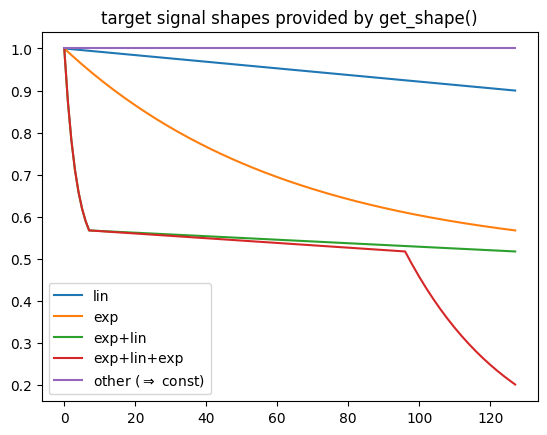

In [3]:
for shape_type in ['lin','exp','exp+lin','exp+lin+exp',r'other ($\Rightarrow$ const)']:
    plt.plot(get_shape(shape_type=shape_type,N=128),label=shape_type)
plt.legend()
plt.title('target signal shapes provided by get_shape()')
plt.show()

done at (j,b_l,b_u,norm)= 14 28.2403564453125 28.245849609375 3.7874656952890416e-08
calculation time: 960.60 milliseconds



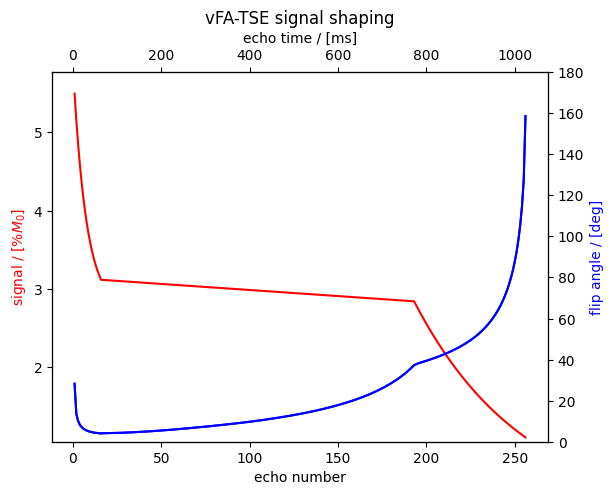

In [4]:
M0   = 1.0
T1   = 800.0
T2   = 50.0
TE   = 4.0
N    = 256

# use basic_epg class if pyepg is not available
EPG = basic_epg(M0, T1, T2, TE/2) if not pyepg_found else pyepg.PyEPG(M0, T1, T2, TE/2)

# target signal shape
shape = get_shape(shape_type='exp+lin+exp',N=N)

# bisectioning to find the maximum first refocusing flip-angle of the vfa train
start_time = datetime.now()
b_l = 0     #FA lower bound
b_u = 180   #FA upper bound
MI  = 100   #max number of iterations
for j in range(MI):
    # try signal shaping with first FA in the middle of the interval
    first_fa = 0.5*(b_l + b_u)
    (s,b) = vfa_tse_signal_shaping(EPG,N,first_fa,shape)
    # shaping successful?
    if np.linalg.norm(s-s[0]*shape) < 1e-6: 
        b_l = first_fa # yes => set lower bound to first FA
    else:                                   
        b_u = first_fa # no  => set upper bound to first FA
    # stop if upper bound is close to lower bound and if last shaping was successful
    if np.isclose(b_u,b_l,atol=1e-2) and b_l == first_fa:
        print('done at (j,b_l,b_u,norm)=',j,b_l,b_u,np.linalg.norm(s-s[0]*shape))
        break
    if j==MI-1:
        print('did not converge in ',MI,' iterations')
delta1 = datetime.now() - start_time
print('calculation time: %.2f milliseconds\n' % (delta1.total_seconds() * 1000))

plot_sig_vfa(s,b,TE,M0)



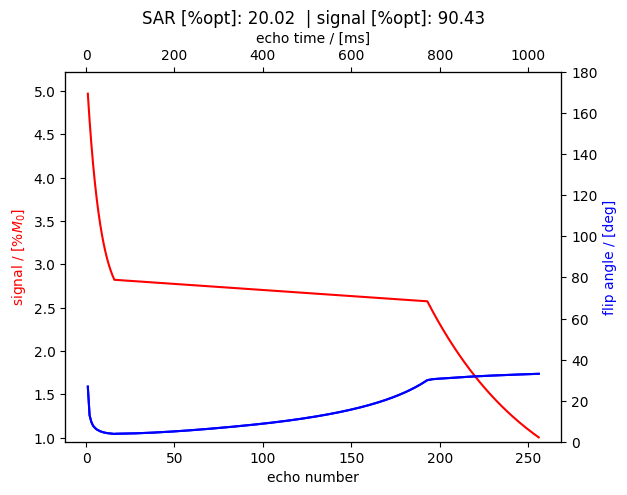

In [5]:
""" 
SAR reduction example as proposed by Pracht et al. [2]

Slightly decreasing the first FA strongly reduces SAR of the vFA train while only slightly reducing the signal level.

[2] E. D. Pracht et al., “SAR and scan-time optimized 3D whole-brain double inversion recovery imaging at 7T,” Magnetic Resonance in Medicine, vol. 79, no. 5, pp. 2620–2628, 2018, doi: 10.1002/mrm.26913.
"""

factor = 0.95 # first FA reduction factor
(sr,br) = vfa_tse_signal_shaping(EPG,N,factor*first_fa,shape)
sar = 100*np.linalg.norm(br**2)/np.linalg.norm(b**2)
sig = 100*np.linalg.norm(sr)/np.linalg.norm(s)

plot_sig_vfa(sr,br,TE,M0,TITLE='SAR [%%opt]: %5.2f  | signal [%%opt]: %5.2f' % (sar,sig))

